In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Basic K-NN with Titanic DataSet

https://www.kaggle.com/competitions/titanic/data

In [2]:
#get data
!git clone https://github.com/s3nnahoj/dsLabData.git

fatal: Zielpfad 'dsLabData' existiert bereits und ist kein leeres Verzeichnis.


In [4]:
DATA_FILE_TRAIN = 'dsLabData/titanic_train.csv' # we only use the annotated data yet
df = pd.read_csv(DATA_FILE_TRAIN, header=0, index_col='PassengerId')
df.loc[df.Age.isnull(),'Age'] = df.Age.median() # fill nan's in age

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

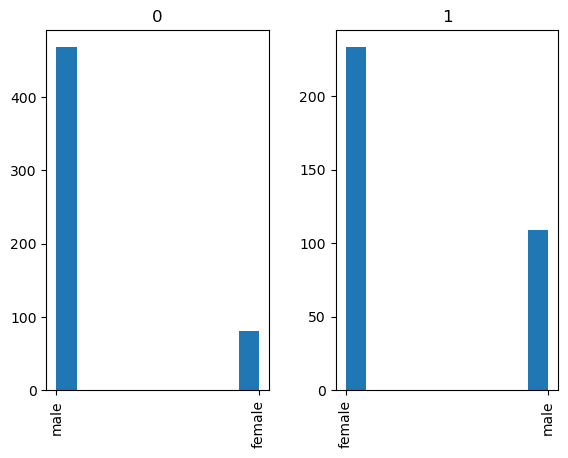

In [7]:
df.hist('Sex',by='Survived')

Survived
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: Fare, dtype: object

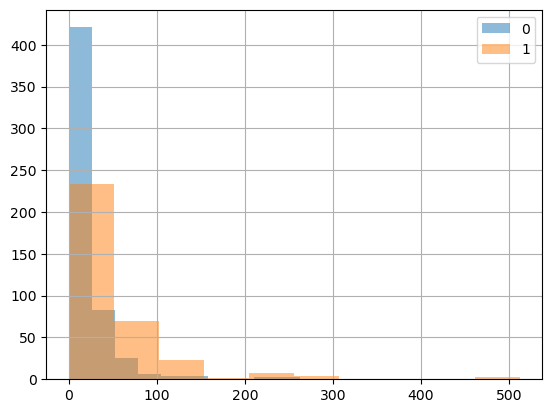

In [8]:
df.groupby('Survived').Fare.hist(legend=True, alpha =0.5)

### Train / Test Split

In [9]:
dfTrain=df.sample(frac=0.8,random_state=42)
dfTest=df.drop(dfTrain.index)

In [11]:
dfTest

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S


### KNN-Classification

In [31]:
def extractFeatureVector(dfRow):
    gender = 0
    if dfRow.Sex == "female":
        gender = 1
    age = (dfRow.Age - dfTrain.Age.mean()) / dfTrain.Age.std()
    return np.array([gender,age])

In [25]:
df.loc[1]

Survived                          0
Pclass                            3
Name        Braund, Mr. Owen Harris
Sex                            male
Age                            22.0
SibSp                             1
Parch                             0
Ticket                    A/5 21171
Fare                           7.25
Cabin                           NaN
Embarked                          S
Name: 1, dtype: object

In [26]:
extractFeatureVector(df.loc[1])

array([-0.54087615])

In [27]:
trainData = []
trainLabel = []

for idx, row in dfTrain.iterrows():
    trainData.append(extractFeatureVector(row))
    trainLabel.append(row.Survived)

In [28]:
def predict(x,k=3):
    distances = [] #(distance,class)
    for idx,tX in enumerate(trainData):
        d = np.linalg.norm(tX-x,ord=1)
        distances.append((d,trainLabel[idx]))
    distances.sort()
    countSurvived = 0
    for i in range(0,k):
        countSurvived+=distances[i][1]
        #print("nn %d with distance %.2f: y=%d" % (i,distances[i][0],distances[i][1]))
    
    if countSurvived >= (k/2.0):
        return 1
    else:
        return 0


In [29]:
predict(extractFeatureVector(dfTest.iloc[0]))    

0

## Evaluation

In [30]:
countCorrect = 0
for idx, row in dfTest.iterrows():
   result = predict(extractFeatureVector(row))
   if result == row.Survived:
      countCorrect+=1

print("correct predictions: %d / %d , accuracy: %.2f " %(countCorrect ,len(dfTest),countCorrect / len(dfTest)))

correct predictions: 113 / 178 , accuracy: 0.63 


# Assignement 4 - Titanic and KNN



1 ) Exploratory data analysis: Further explore the Titanic data set by summarizing statiscis and data visualization. In particular focus on:
  
  * the distribution of the individual features. are they quantitative or qualitative? what about the possible range of values?
  * the class conditional distributions. how are the features distributed for the survived / not survived case.
  * which features are discriminative?

2) Extend the given KNN implementation by adding more features. Play around and evaluate your changes. Can you increase the accuracy on the given split? 